Notebook 03 — XGBoost Classification Model


Import Libraries


In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the cleaned OHLCV dataset exported from Notebook 2
df = pd.read_csv("data/processed/ohlc_clean.csv")

# Convert timestamp to datetime if needed
if "timestamp" in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index("timestamp", inplace=True)

# --- Correct target: next 1-hour candle direction ---
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

# Clean rows with NaN caused by shift
df.dropna(inplace=True)

print(df[['close', 'target']].head())
print("Dataset shape:", df.shape)


      close  target
0  13529.01       0
1  13203.06       1
2  13330.18       1
3  13410.03       1
4  13601.01       0
Dataset shape: (69332, 7)


Load Features

In [37]:
import ta
import numpy as np

def build_features(df):
    X = pd.DataFrame(index=df.index)

    # === PRICE RETURNS ===
    X['return_1'] = df['close'].pct_change()
    X['return_5'] = df['close'].pct_change(5)
    X['return_10'] = df['close'].pct_change(10)

    # === VOLATILITY ===
    X['volatility_10'] = df['close'].pct_change().rolling(10).std()
    X['volatility_20'] = df['close'].pct_change().rolling(20).std()

    # === RSI ===
    X['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()

    # === STOCHASTIC ===
    stoch = ta.momentum.StochasticOscillator(
        high=df['high'],
        low=df['low'],
        close=df['close']
    )
    X['stoch_k'] = stoch.stoch()
    X['stoch_d'] = stoch.stoch_signal()

    # === MACD ===
    macd = ta.trend.MACD(df['close'])
    X['macd'] = macd.macd()
    X['macd_signal'] = macd.macd_signal()
    X['macd_diff'] = macd.macd_diff()

    # === BOLLINGER BANDS ===
    bb = ta.volatility.BollingerBands(df['close'])
    X['bb_high'] = bb.bollinger_hband()
    X['bb_low'] = bb.bollinger_lband()
    X['bb_width'] = X['bb_high'] - X['bb_low']

    # === VOLUME FEATURES ===
    X['volume_change'] = df['volume'].pct_change()

    # === YOUR STRATEGY FEATURES ===
    # Sideways (low volatility)
    X["volatility_1h"] = df["close"].pct_change().rolling(20).std()
    X["sideways"] = (X["volatility_1h"] < X["volatility_1h"].median()).astype(int)

    # Volume spikes
    X["vol_mean_24h"] = df["volume"].rolling(24).mean()
    X["vol_std_24h"] = df["volume"].rolling(24).std()
    X["volume_spike"] = (df["volume"] - X["vol_mean_24h"]) / X["vol_std_24h"]

    # Max-pain drawdown (fear)
    roll_max = df["close"].rolling(72).max()
    X["drawdown"] = (df["close"] - roll_max) / roll_max

    # Greed (overheated rally)
    roll_min = df["close"].rolling(72).min()
    X["rally"] = (df["close"] - roll_min) / roll_min

    # Remove temp columns
    X.drop(['vol_mean_24h','vol_std_24h'], axis=1, inplace=True)

    # DROP NaN
    X = X.dropna()

    return X


features = build_features(df)
target = df.loc[features.index, 'target']  # PERFECT ALIGNMENT

print("Feature shape:", features.shape)
print("Target shape:", target.shape)


Feature shape: (69261, 20)
Target shape: (69261,)


Train/Test Split + Scaling  

In [39]:
X = features
y = target

# --- FIX: remove NaN and infinite values ---
X = X.replace([float('inf'), float('-inf')], pd.NA)
X = X.dropna()
y = y.loc[X.index]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


X_train: (55406, 20)
X_test: (13852, 20)


Train XGBoost Model

In [40]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    min_child_weight=3,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
print("Model training complete!")


Model training complete!


Evaluation + Threshold Tuning

In [41]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.55).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.5171816344210223
F1 score: 0.3665466944497064
ROC-AUC: 0.5385645157187648

Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.76      0.61      6842
           1       0.55      0.28      0.37      7010

    accuracy                           0.52     13852
   macro avg       0.53      0.52      0.49     13852
weighted avg       0.53      0.52      0.49     13852



Feature Importance Plot

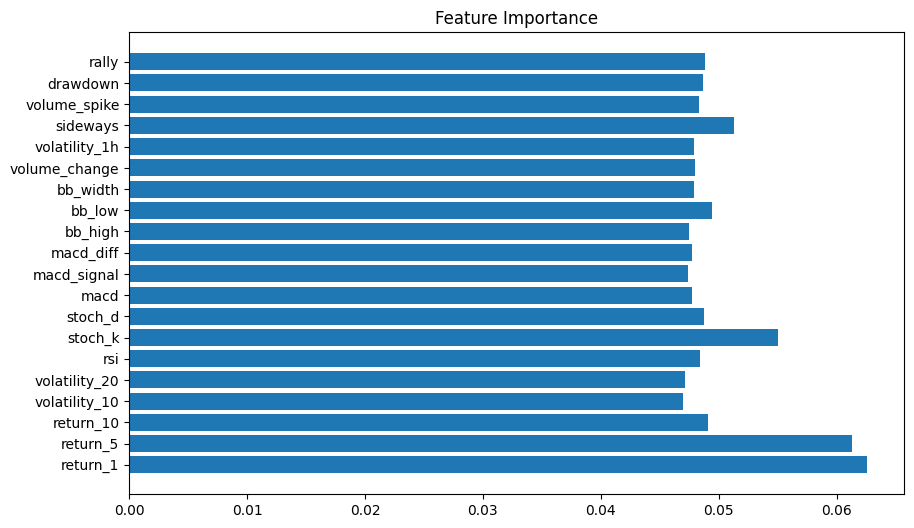

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance")
plt.show()




Save Model

In [46]:
import joblib

# Save model in the current folder
joblib.dump(model, "xgboost_trend_model.pkl")

# Later, to load it:
# model = joblib.load("xgboost_trend_model.pkl")


['xgboost_trend_model.pkl']